## Data Science Internship
#### Análise Exploratória
##### Autor: Pedro Henrique Braga Lisboa

#### Sumário
----
* [Pré-processamento e limpeza](#load-data)
* [Contagem de valores faltantes por variável](#missing_values)
    * [Distribuição dos valores faltantes](#missing_distribution)
* [Variação PT08.S1(CO) de acordo com o horário](#var_horario)
    * [Horários de pico na quarta feira](#horarios_quarta)
* [Correlação entre variáveis](#corr_vars)
* [Análise de estacionariedade e não-linearidade](#an_stat)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import itertools

from functions import plot_daily_data, get_na_sequences

%matplotlib inline
matplotlib.rc('font', family='Arial')
sns.set_style("whitegrid")

Using TensorFlow backend.


### Pré-processamento e limpeza  <a name="load-data"></a>
-----------

In [2]:
dataset = pd.read_csv("qualidade_do_ar.csv", sep=';')
for column in dataset:
    print(column + ': ' + str(dataset[column].dtype))
    if column in ["T", "RH", "AH", "C6H6(GT)"]:
        dataset[column] = dataset[column].apply(lambda x: x.replace(',',".")).astype('float64')


dataset.replace(to_replace=-200, value=np.NaN, inplace=True)

timestamp = (dataset["Date"] + ' ' + dataset["Time"]).apply(lambda x: x.replace('.', ':'))
dataset["timestamp"] = pd.to_datetime(timestamp, dayfirst=True)
dataset["Time"] = pd.to_datetime(dataset["Time"].apply(lambda x: x.replace('.',":")), 
                                 dayfirst=True, format='%H:%M:%S')
# dataset.set_index(["Date", "Time"],inplace=True)
dataset["Weekday"] = dataset["timestamp"].dt.day_name()
dataset["Hour"] = dataset["timestamp"].dt.hour


dataset.to_csv("qualidade_do_ar_padronizado.csv", index=False)

Date: object
Time: object
PT08.S1(CO): int64
NMHC(GT): int64
C6H6(GT): object
PT08.S2(NMHC): int64
NOx(GT): int64
PT08.S3(NOx): int64
NO2(GT): int64
PT08.S4(NO2): int64
PT08.S5(O3): int64
T: object
RH: object
AH: object


### Contagem de valores faltantes por variável <a name="missing_values"></a>
---


In [3]:
na_count = dataset.isna().sum()

columns_with_na = na_count[na_count !=0].index.values
na_count

Date                0
Time                0
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
timestamp           0
Weekday             0
Hour                0
dtype: int64

#### Distribuição dos valores faltantes <a name="missing_distribution"></a>
---

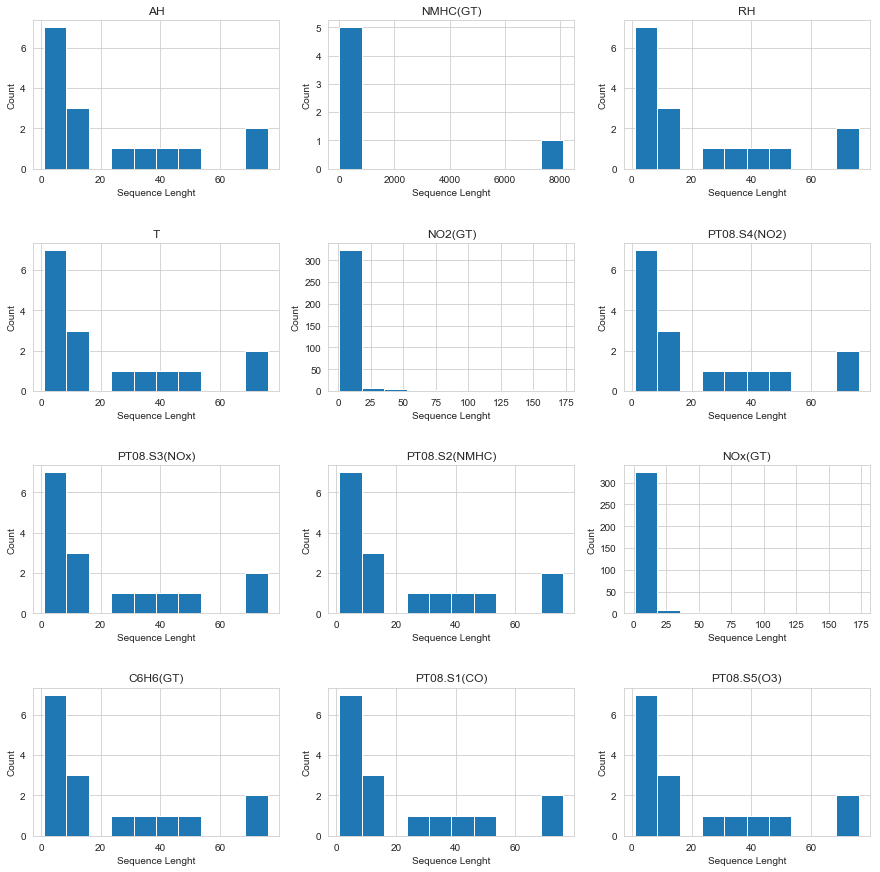

In [4]:
missing_data = dataset[columns_with_na]
# missing_data = dataset.drop(["Date", "timestamp", "Hour", "Weekday", "Time", "C6H6(GT)", "T", "RH", "AH"],
#                             axis='columns')
na_sequences = dict()
for column in missing_data:
    na_sequences[column] = get_na_sequences(missing_data, column)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for ax, column in zip(axes.flatten(),na_sequences):
    ax.hist(na_sequences[column])
    ax.set_title(column)
    ax.set_xlabel("Sequence Lenght")
    ax.set_ylabel("Count")

#### A maior parte dos valores faltantes está concentrada em intervalos que variam de algumas horas até 2 ou 3 dias, tornando possível algumas estratégias para o seu preenchimento. No caso da variável NMHC(GT), boa parte de seus valores está faltando em um intervalo com meses de comprimento.

### Variação PT08.S1(CO) de acordo com o horário  <a name="var_distribution"></a>

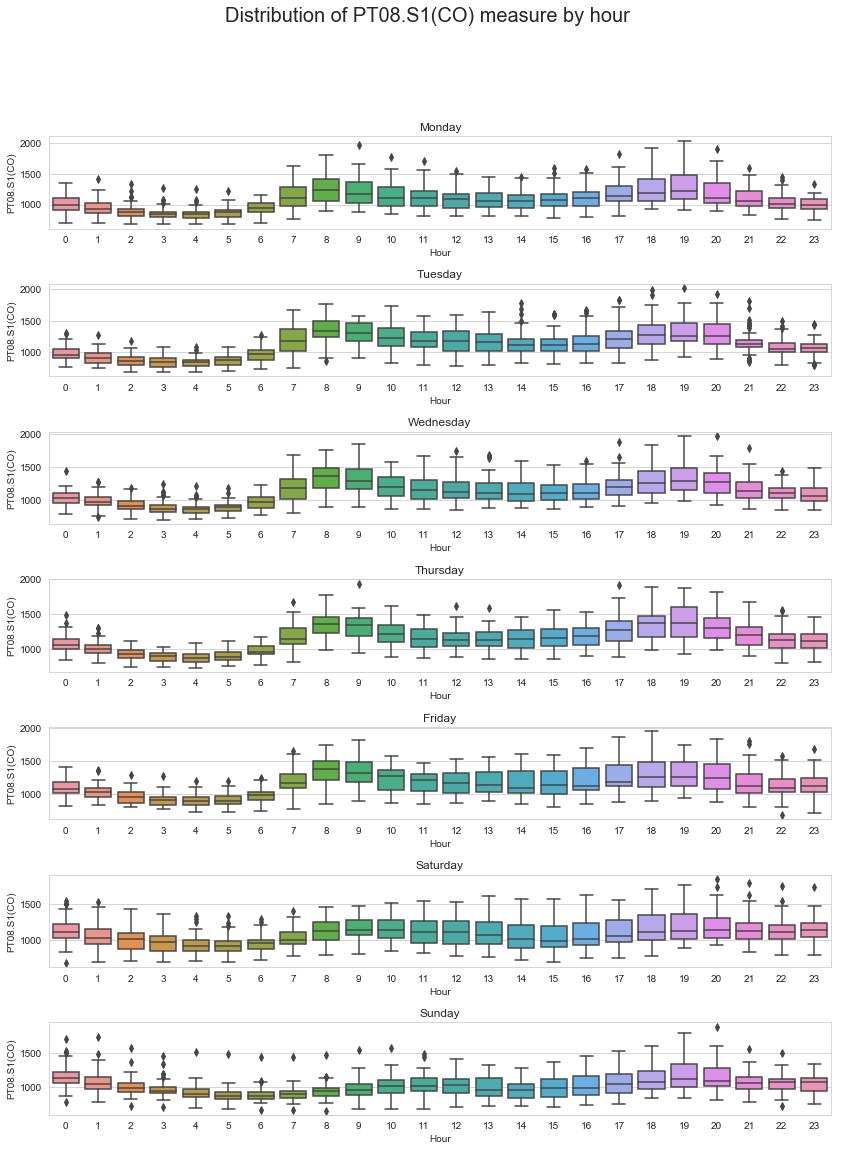

In [5]:
fig, axes = plt.subplots(nrows=7, figsize=(14, 18)) #week days
plt.subplots_adjust(hspace=0.6)
an_var = "PT08.S1(CO)"

for i,ax in enumerate(axes):
    f_dataset = dataset[dataset.timestamp.dt.dayofweek == i][["Hour", "timestamp", an_var]]
    sns.boxplot(ax=ax, data=f_dataset, x="Hour", y=an_var)
    ax.set_title(f_dataset.timestamp.dt.day_name().iloc[0])
fig.suptitle("Distribution of PT08.S1(CO) measure by hour", fontsize=20);

#### Horários de pico na quarta-feira <a name="horarios_quarta"></a>
---

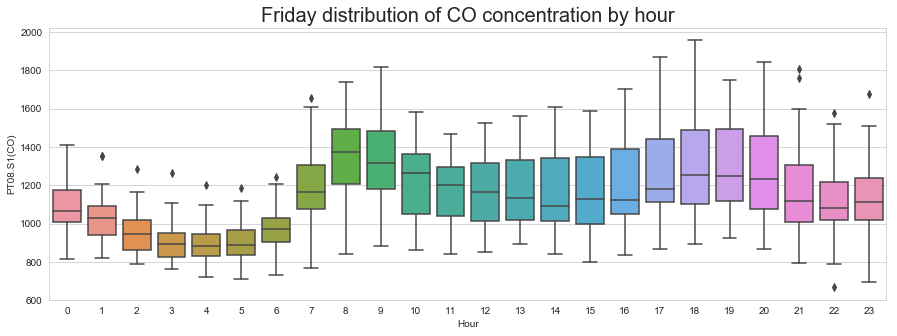

In [6]:
f_dataset = dataset[dataset.timestamp.dt.dayofweek == 4][["Hour", "timestamp", an_var]]
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(ax=ax,data=f_dataset, x="Hour", y=an_var)
ax.set_title(f_dataset.timestamp.dt.day_name().iloc[0] + ' distribution of CO concentration by hour',
            fontsize=20);

#### Observando o gráfico acima, observa-se que as maiores concentrações de CO ocorrem pela manhã, no intervalo de 8 até 9 horas, e no final do dia, entre 18 e 19 horas. 
#### O padrão cíclico e os horários de pico identificados fazem sentido no local de coleta dos dados: em um ambiente urbano (perto de uma rua), os horários de baixa circulação de automóveis ocorrem antes do amanhecer; já os horários de pico estão alinhados com os horários de início e fim da jornada de trabalho da maioria das profissões, quando há grande movimentação pela cidade.       

### Correlação entre variaveis <a name="corr_vars"></a>
---

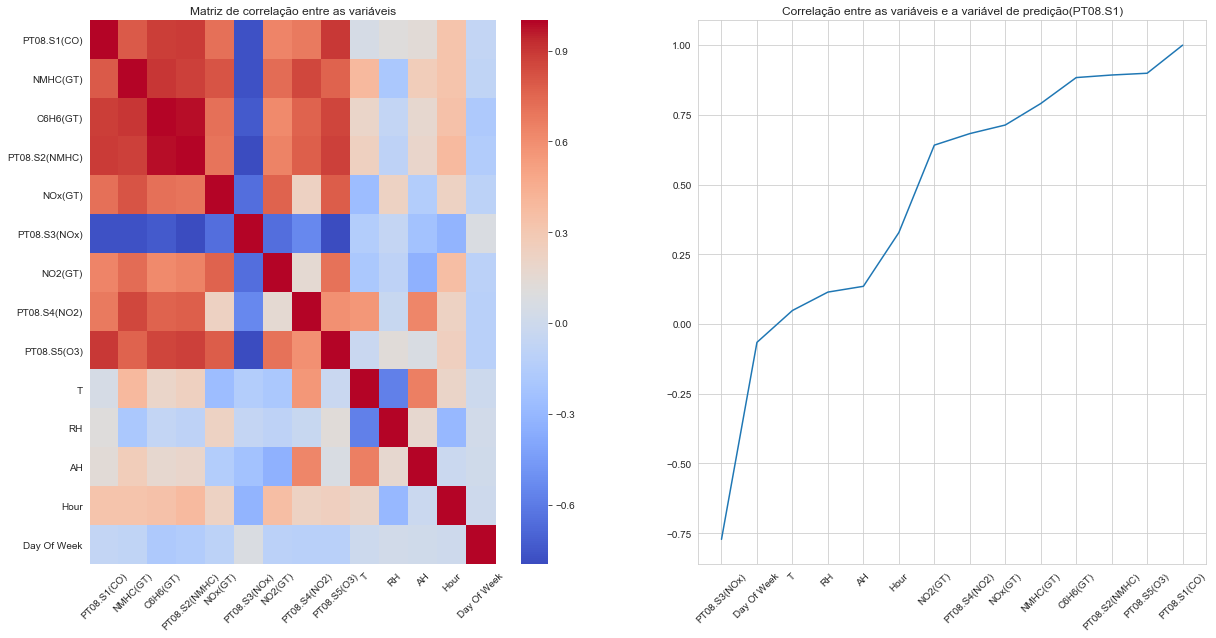

In [7]:
dataset["Day Of Week"] = dataset["timestamp"].dt.dayofweek
corr_mat = dataset.corr() #pearson
fig, axes = plt.subplots(ncols=2,figsize=(20,10))
sns.heatmap(corr_mat,cmap="coolwarm", ax=axes[0]);
axes[0].set_title(u"Matriz de correlação entre as variáveis")
axes[0].tick_params(axis='x', rotation=45)

axes[1].plot(corr_mat["PT08.S1(CO)"].sort_values())
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_title(u"Correlação entre as variáveis e a variável de predição(PT08.S1)");
dataset.drop("Day Of Week", axis=1, inplace=True)

#### Os resultados do dispositivo multisensor são fortemente correlacionados com a variável de predição. Dentre esses (PTXX.SX), a variável PT08.S3 é a única negativamente correlacionada com as outras e a variável de predição. Além dessas, temos os resultados dos outros sensores: NO2(GT), NOx(GT), C6H6(G6), NMHC(GT), também fortemente correlacionados (positivamente) com a variável de predição.  

#### Entre as variáveis, temos PT08.S5(O3), PT08.S2(NMHC), C6H6(GT), PT08.S3(NOx) mais fortemente correlacionadas com a variável de predição, sendo a última PT08.S3(NOx) negativamente correlacionada.

### Análise de estacionariedade e não-linearidade <a name="an_stat"></a>
---

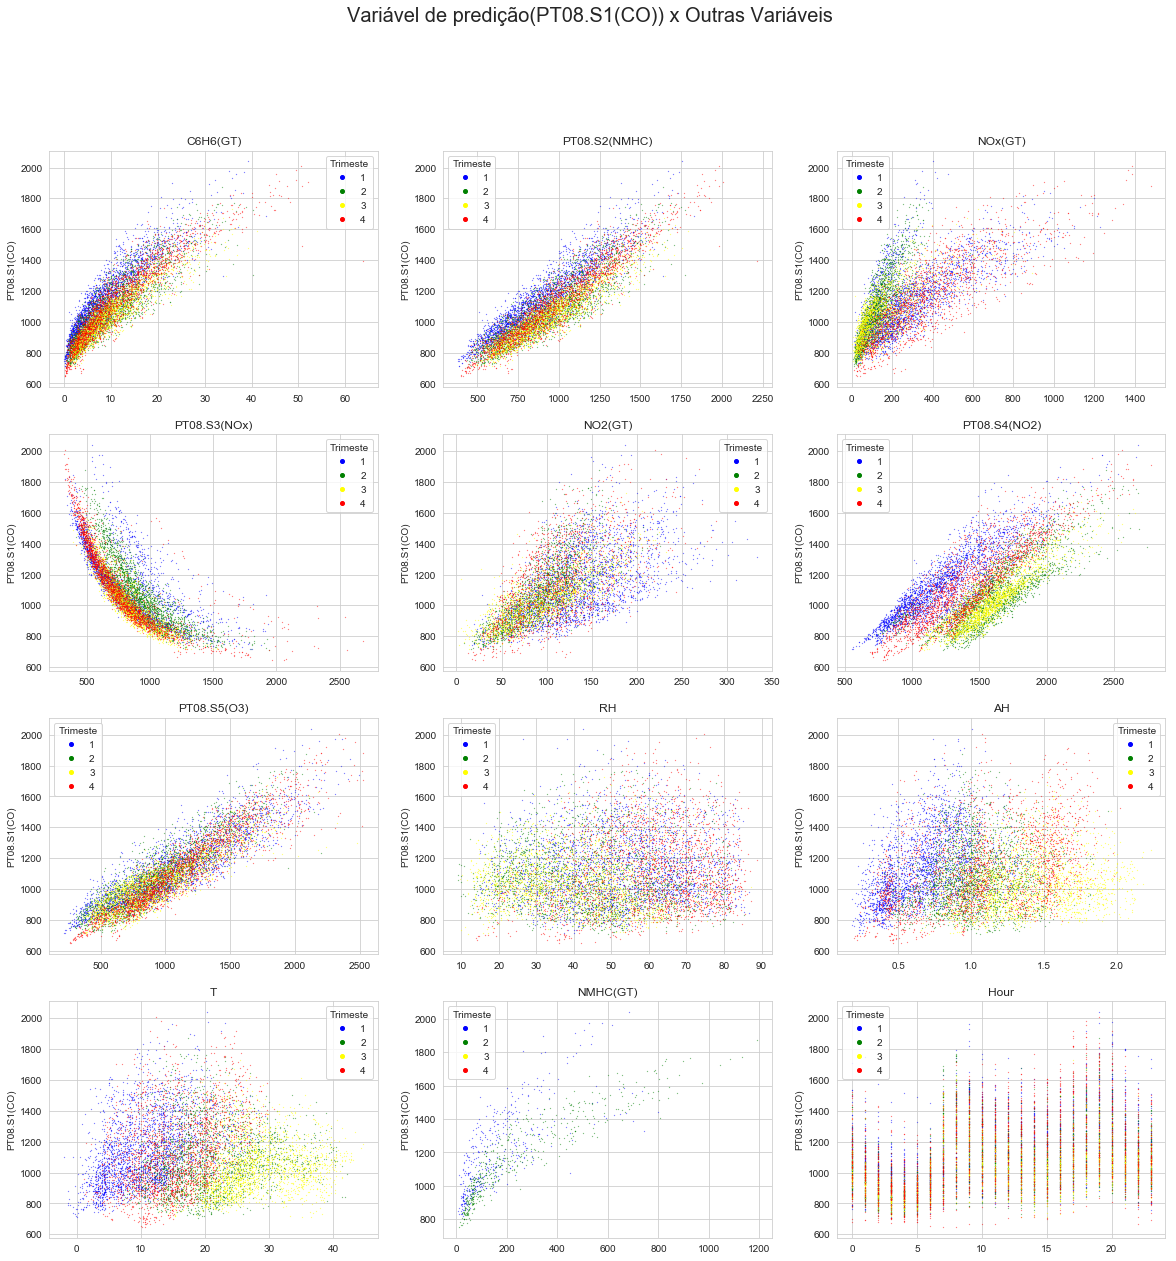

In [8]:
regressor_vars = ['C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
                  'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 
                  'RH', 'AH', 'T', 'NMHC(GT)', "Hour"]
pred_var = 'PT08.S1(CO)'

dataset["quarter"] = pd.to_datetime(dataset["timestamp"]).dt.quarter
fig, axes = plt.subplots(ncols=3, nrows = 4, figsize=(20,20))
for i, (ax, var) in enumerate(zip(axes.flatten(), regressor_vars)):
#     ax.hexbin(x=dataset[var], y=dataset[pred_var])
    colors = ["blue", "green", "yellow", "red"]
    for quarter in [1,2,3,4]: 
        ax.plot(var, pred_var, data=dataset[dataset.quarter==quarter], label=quarter,
                linestyle='', marker='o', markersize=0.2, color=colors[quarter-1])
        ax.set_title(var)
        ax.set_ylabel(pred_var)
        ax.legend(markerscale=20, title="Trimeste")
fig.suptitle("Variável de predição(" + pred_var + ") x Outras Variáveis", fontsize=20);

##### Acima estão apresentados graficos das relações entre a variável de predição (eixo x) e as outras variáveis (eixo y). Incialmente, pode-se observar visualmente os resultados obtidos da análise da matriz de correlação. 
##### É possível também observar que algumas variáveis (como a PT08.S3(NOx) e C6H6(GT)) possuem uma relação não-linear com a variável de predição. 
##### Por fim, pelo agrupamento dos dados por trimestre, nota-se que a distribuição conjunta da variável de predição com outras variáveis varia de acordo com a época do ano. O efeito pode ser visualizado para a distribuição de PT08.S4(NO2) no gráfico abaixo.
##### Conclui-se que os dados são não estacionários ou cicloestacionários, com a distribuição dos dados possívelmente variando ciclicamente a cada ano de acordo com a estação. 
##### Para o treinamento de um modelo a partir dos dados, isso levanta um problema, uma vez que há um desvio contínuo ao longo do tempo das características a serem capturadas pelo modelo. No caso da cicloestacionariedade e da presença de mais dados, um modelo poderia ser treinado para cada estação do ano. Teria-se, portanto, quatro modelos que se alternariam dependendo da data na qual a predição estivesse ocorrendo. Uma alternativa mais geral seria a criação de um ensemble de modelos treinados de forma a combater o efeito do desvio das características. Por fim, uma terceira opção consistiria em um sistema online, no qual o modelo fosse constantemente treinado com novos dados recebidos pelos sensores, de forma a acompanhar a mudança das propriedades estatísticas dos dados. 

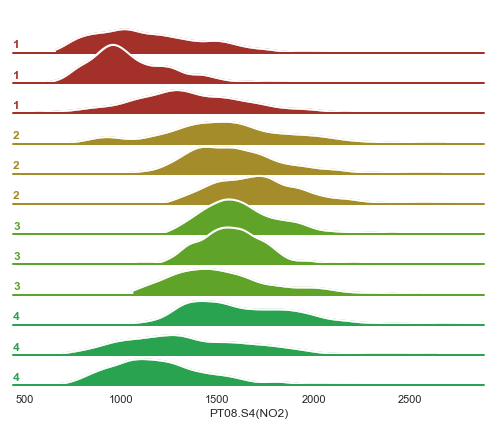

In [9]:
import warnings
warnings.filterwarnings("ignore")
# Código adaptado de: https://seaborn.pydata.org/examples/kde_ridgeplot.html
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

dataset["Month"] = pd.to_datetime(dataset["timestamp"]).dt.month
pal = sns.hls_palette(8, l=.4, s=.6)#(10, rot=-.25, light=.7)
g = sns.FacetGrid(dataset, row="Month", hue="quarter", aspect=15, height=.5, palette=pal)

g.map(sns.kdeplot, "PT08.S4(NO2)", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "PT08.S4(NO2)", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "PT08.S4(NO2)")

g.fig.subplots_adjust(hspace=-.25)

g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

#### No gráfico acima, os valores no eixo y e a coloração indicam o trimestre da distribuição.

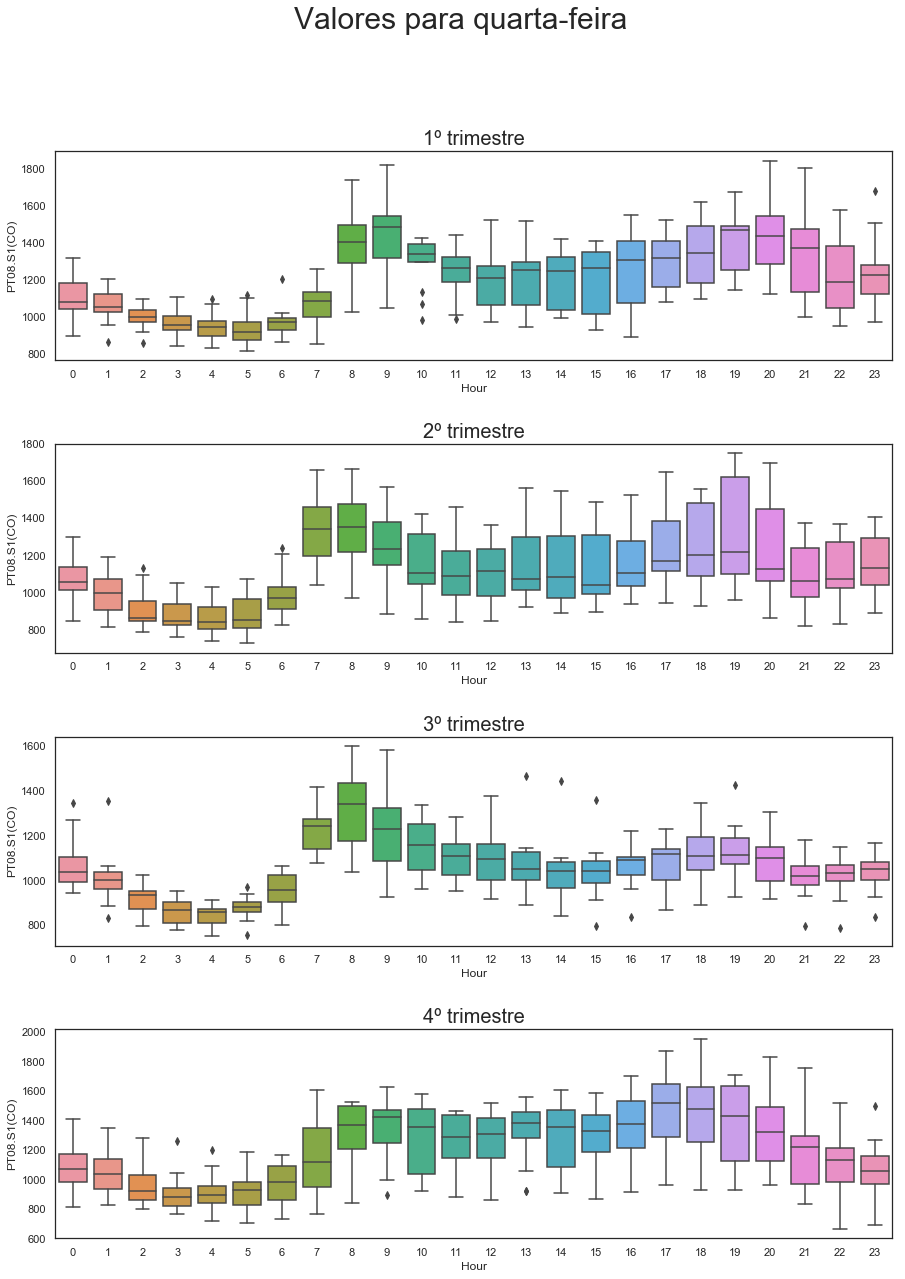

In [13]:
f_dataset = dataset[dataset.timestamp.dt.dayofweek == 4][["quarter", "Hour", "timestamp", an_var]]
fig, axes = plt.subplots(nrows=4,figsize=(15,20))
for ax, (gn, g) in zip(axes.flatten(), f_dataset.groupby("quarter")):
    sns.boxplot(ax=ax,data=g, x="Hour", y=an_var)
    ax.set_title(str(g.timestamp.dt.quarter.iloc[0]) + "º trimestre",# + ' distribution of CO concentration by hour',
                fontsize=20);
plt.subplots_adjust(hspace=0.4)
fig.suptitle("Valores para quarta-feira", fontsize=30);